<!-- Task Title -->

<div style="background-color: #708d90; padding: 20px; border-radius: 10px; box-shadow: 5px 5px 10px #888888;">
  <h1 style="color: white; font-size: 30px; font-weight: bold; text-align: center; text-shadow: 2px 2px 4px #000000;">Phishing URL Detection🔍🤖</h1>
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import pickle
pd.set_option('display.max_columns', None)

# Import Dataset

In [2]:
# Import Dataset
df = pd.read_csv('/content/dataset_phishing.csv')
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,3,0,0,0,0,0,0,4,4,3,3,3,11,11,6,5.750000,7.0,4.500000,0,0,0,0,0,0,17,0.529412,0.470588,0,0,0,0.875000,0,0.500000,0,0,80.000000,0,100.000000,0.000000,0,0,0,0.0,0,0,0,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0,0,1,0.220779,0.0,0,0,0,0,0,1,0,0,0,0,1,0,4,4,2,19,2,32,19,32,15.750000,19.0,14.666667,0,0,0,0,0,0,30,0.966667,0.033333,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,80.000000,20.000000,0,0,0,100.0,0,0,0,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,3,2,0,0,5,0,1,0,0,0,0,0,1,0,0,0,0.150794,0.0,0,0,0,1,0,3,1,0,0,0,1,0,12,2,2,3,2,17,13,17,8.250000,8.4,8.142857,0,0,0,0,0,0,4,1.000000,0.000000,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,0.000000,0.000000,0,0,0,100.0,0,0,0,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,1,0,5,5,0,5,5,0,5.000000,5.0,0.000000,0,0,0,0,0,0,149,0.973154,0.026846,0,0,0,0.250000,0,0.250000,0,0,100.000000,0,96.428571,3.571429,0,0,0,62.5,0,0,0,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,6,3,3,3,4,11,7,11,6.333333,5.0,7.000000,0,0,0,0,0,0,102,0.470588,0.529412,0,0,0,0.537037,0,0.018519,1,0,76.470588,0,0.000000,100.000000,0,0,0,0.0,0,0,0,0,1,0,224,8175,8725,0,0,6,legitimate


In [3]:
df.isna().sum()



,0
url,0
length_url,0
length_hostname,0
ip,0
nb_dots,0
...,...
web_traffic,0
dns_record,0
google_index,0
page_rank,0


In [4]:
# removing missing values

df.dropna(inplace=True)

In [5]:
features = [
    'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq',
    'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn',
    'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url',
    'ratio_digits_host', 'punycode', 'shortening_service', 'path_extension', 'phish_hints', 'domain_in_brand',
    'brand_in_subdomain', 'brand_in_path', 'suspecious_tld'
]

In [6]:
# target feature mapping

df['status'] = df['status'].map({'phishing': 1, 'legitimate': 0})

In [7]:
df['status'].value_counts()

,count
status,
0,5715
1,5715


In [8]:
df.describe()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
count,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.0,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.0,11430.000000,11430.0,11430.000000,11430.0,11430.000000,11430.000000,11430.000000,11430.000000,11430.0,11430.000000,11430.000000,11430.0,11430.000000,11430.000000,11430.000000,11430.000000,11430.00000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,1.143000e+04,11430.000000,11430.000000,11430.000000,11430.000000
mean,61.126684,21.090289,0.150569,2.480752,0.997550,0.022222,0.141207,0.162292,0.0,0.293176,0.322660,0.006649,0.123097,4.289589,0.000700,1.027909,0.004024,0.062292,0.001925,0.034821,0.448469,0.127997,0.006562,0.016710,0.610936,0.053137,0.025024,0.000350,0.002362,0.065617,0.050131,0.021610,2.231671,0.202450,0.083290,0.123447,0.000175,0.498250,0.003150,6.232808,2.927472,3.127297,5.019773,2.398950,15.393876,10.467979,10.561505,7.258882,7.678075,5.092425,0.327734,0.104199,0.004112,0.004899,0.017935,0.059755,87.189764,0.602457,0.276720,0.0,0.784864,0.0,0.158926,0.0,0.062469,0.063605,0.442170,51.978211,0.0,42.870444,23.236293,0.0,0.001312,0.006037,37.063922,0.001137,0.00140,0.124759,0.775853,0.439545,0.072878,492.532196,4062.543745,8.567566e+05,0.020122,0.533946,3.185739,0.500000
std,55.297318,10.777171,0.357644,1.369686,2.087087,0.155500,0.364456,0.821337,0.0,0.998317,1.093336,0.081274,1.466450,1.882251,0.026448,0.240325,0.103240,0.598190,0.077111,0.375576,0.501912,0.379008,0.080742,0.169358,0.487559,0.089363,0.093422,0.018705,0.048547,0.247622,0.218225,0.145412,0.637069,0.401843,0.276332,0.328964,0.013227,0.691907,0.056035,5.572355,4.768936,2.211571,3.941580,2.997809,22.083644,4.932015,23.077883,4.145827,3.578435,7.147050,0.842600,0.305533,0.063996,0.069827,0.132722,0.331266,166.758254,0.376474,0.319958,0.0,2.758802,0.0,0.266437,0.0,0.156209,0.244058,0.496666,41.523144,0.0,46.249897,38.386577,0.0,0.036204,0.077465,39.073385,0.033707,0.03739,0.330460,0.417038,0.496353,0.259948,814.769415,3107.784600,1.995606e+06,0.140425,0.498868,2.536955,0.500022
min,12.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.0000

In [9]:
df.shape

(11430, 89)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

In [11]:
# Select only the numerical columns from the dataframe
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix on the numerical columns
corr_matrix = numerical_df.corr()

In [12]:
status_corr = corr_matrix['status']
status_corr.shape

(88,)

In [13]:
# Function for selecting features that are above than threshold value

def feature_selector_correlation(cmatrix, threshold):

    selected_features = []
    feature_score = []
    i=0
    for score in cmatrix:
        if abs(score)>threshold:
            selected_features.append(cmatrix.index[i])
            feature_score.append( ['{:3f}'.format(score)])
        i+=1
    result = list(zip(selected_features,feature_score))
    return result

In [14]:
features_selected = feature_selector_correlation(status_corr, 0.2)
features_selected

[('length_url', ['0.248580']),
 ('length_hostname', ['0.238322']),
 ('ip', ['0.321698']),
 ('nb_dots', ['0.207029']),
 ('nb_qm', ['0.294319']),
 ('nb_eq', ['0.233386']),
 ('nb_slash', ['0.242270']),
 ('nb_www', ['-0.443468']),
 ('ratio_digits_url', ['0.356395']),
 ('ratio_digits_host', ['0.224335']),
 ('tld_in_subdomain', ['0.208884']),
 ('prefix_suffix', ['0.214681']),
 ('shortest_word_host', ['0.223084']),
 ('longest_words_raw', ['0.200147']),
 ('longest_word_path', ['0.212709']),
 ('phish_hints', ['0.335393']),
 ('nb_hyperlinks', ['-0.342628']),
 ('ratio_intHyperlinks', ['-0.243982']),
 ('empty_title', ['0.207043']),
 ('domain_in_title', ['0.342807']),
 ('domain_age', ['-0.331889']),
 ('google_index', ['0.731171']),
 ('page_rank', ['-0.511137']),
 ('status', ['1.000000'])]

In [15]:
selected_features = []
for feature, score in features_selected:
    if feature != 'status':
        selected_features.append(feature)

In [16]:
selected_features

['length_url',
 'length_hostname',
 'ip',
 'nb_dots',
 'nb_qm',
 'nb_eq',
 'nb_slash',
 'nb_www',
 'ratio_digits_url',
 'ratio_digits_host',
 'tld_in_subdomain',
 'prefix_suffix',
 'shortest_word_host',
 'longest_words_raw',
 'longest_word_path',
 'phish_hints',
 'nb_hyperlinks',
 'ratio_intHyperlinks',
 'empty_title',
 'domain_in_title',
 'domain_age',
 'google_index',
 'page_rank']

# Train Test Split & Feature Scaling

In [17]:
X = df[selected_features]
y = df['status']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training

In [20]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

In [21]:
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10]
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 1]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7,9],
        'p': [1, 2]
    }
}


In [22]:
results = {}
for name, clf in classifiers.items():
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grids[name], cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train)
    results[name] = grid_search



In [23]:
for name, grid_search in results.items():
    print(f"{name}:")
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", test_accuracy)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print()


Logistic Regression:
Best Parameters: {'C': 10}
Best Score: 0.9321055550074672
Test Accuracy: 0.9384184744576627
Confusion Matrix:
 [[1332   90]
 [  86 1350]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      1422
           1       0.94      0.94      0.94      1436

    accuracy                           0.94      2858
   macro avg       0.94      0.94      0.94      2858
weighted avg       0.94      0.94      0.94      2858


Random Forest:
Best Parameters: {'max_depth': 20, 'n_estimators': 200}
Best Score: 0.9619697160411089
Test Accuracy: 0.9583624912526242
Confusion Matrix:
 [[1362   60]
 [  59 1377]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      1422
           1       0.96      0.96      0.96      1436

    accuracy                           0.96      2858
   macro avg       0.96      0.96      0.96      2858
weighted av

In [24]:
print("Summary of Best Models:")
for name, grid_search in results.items():
    print(f"{name}:")
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score (CV):", grid_search.best_score_)
    print()

Summary of Best Models:
Logistic Regression:
Best Parameters: {'C': 10}
Best Score (CV): 0.9321055550074672

Random Forest:
Best Parameters: {'max_depth': 20, 'n_estimators': 200}
Best Score (CV): 0.9619697160411089

Gradient Boosting:
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 200}
Best Score (CV): 0.9588200754547527

SVM:
Best Parameters: {'C': 10, 'kernel': 'rbf'}
Best Score (CV): 0.9564866253219074

KNN:
Best Parameters: {'n_neighbors': 3, 'p': 1}
Best Score (CV): 0.9510034665641551



### Random Forest:

Best Parameters:
- {'max_depth': 20, 'n_estimators': 100}

Best Score (CV): 0.960330667356124

In [25]:
rf_model=RandomForestClassifier(max_depth=20,n_estimators=100)
rf_model.fit(X_train,y_train)


RandomForestClassifier(max_depth=20)

In [26]:
# saving model for deployment
with open("phishing_rf_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)


In [27]:
y_pred=rf_model.predict(X_test)

In [28]:
def evaluate_model(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()


Accuracy: 0.9618614415675297
Precision: 0.9610840861709521
Recall: 0.963091922005571

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      1422
           1       0.96      0.96      0.96      1436

    accuracy                           0.96      2858
   macro avg       0.96      0.96      0.96      2858
weighted avg       0.96      0.96      0.96      2858



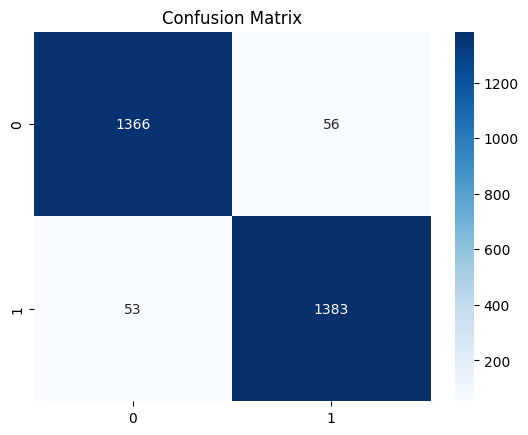

In [29]:
evaluate_model(y_test,y_pred)

In [30]:
from sklearn.svm import SVC
import seaborn as sns
from sklearn.pipeline import Pipeline

Accuracy: 0.9622113365990203
Precision: 0.967605633802817
Recall: 0.9568245125348189

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      1422
           1       0.97      0.96      0.96      1436

    accuracy                           0.96      2858
   macro avg       0.96      0.96      0.96      2858
weighted avg       0.96      0.96      0.96      2858



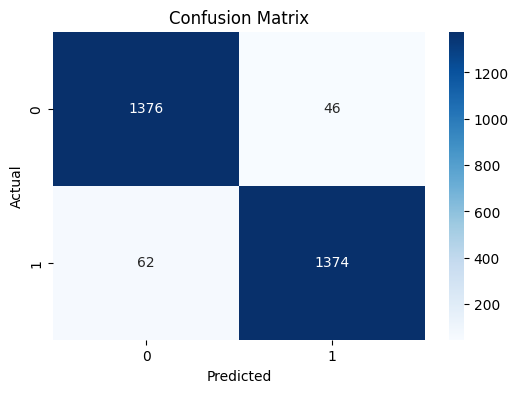

In [31]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42))
])

# Train the model
svm_pipeline.fit(X_train, y_train)

# Predict
y_pred = svm_pipeline.predict(X_test)

# --- Step 3: Evaluation ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [32]:
# SAVE MODEL
with open("phishing_svm_model.pkl", "wb") as f:
    pickle.dump(svm_pipeline, f)

KNN Accuracy: 0.9471658502449265
KNN Precision: 0.9496151154653604
KNN Recall: 0.9449860724233984

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95      1422
           1       0.95      0.94      0.95      1436

    accuracy                           0.95      2858
   macro avg       0.95      0.95      0.95      2858
weighted avg       0.95      0.95      0.95      2858



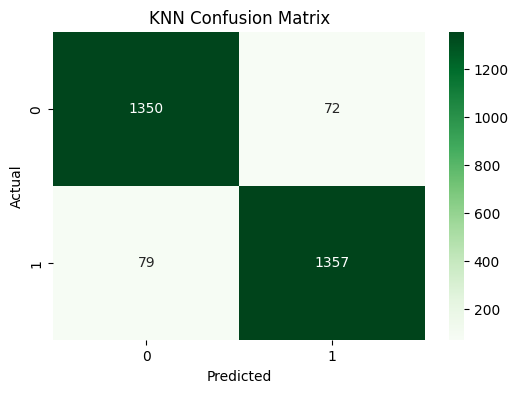

In [33]:
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=3))
])

# Train model
knn_pipeline.fit(X_train, y_train)

# Predict
y_pred_knn = knn_pipeline.predict(X_test)

# --- Step 3: Evaluation ---
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN Precision:", precision_score(y_test, y_pred_knn))
print("KNN Recall:", recall_score(y_test, y_pred_knn))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred_knn))

# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt="d", cmap="Greens")
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [34]:
#save knn model
with open("phishing_knn_model.pkl", "wb") as f:
    pickle.dump(knn_pipeline, f)

In [35]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.0 MB/s eta 0:00:00


In [36]:
!pip install whois

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 1.7 MB/s eta 0:00:00


In [37]:
import gradio as gr
from urllib.parse import urlparse
import re
import numpy as np
import requests
from bs4 import BeautifulSoup
import whois
from datetime import datetime
import pandas
import pickle

with open("/content/phishing_svm_model.pkl", "rb") as f:
    svm_pipeline = pickle.load(f)
with open("/content/phishing_knn_model.pkl", "rb") as f:
    knn_pipeline = pickle.load(f)
with open("/content/phishing_rf_model.pkl", "rb") as f:
    rf_pipeline = pickle.load(f)



# ========== CONFIGURE YOUR API KEYS HERE ==========
MOZ_ACCESS_ID = "MOZ_ACCESS_ID"
MOZ_SECRET_KEY = "MOZ_SECRET"
SERPAPI_KEY = "SERPAPI_KEY"


# Map features to their source
feature_sources = {
    # Auto-extracted features
    'length_url': 'Calculated from URL', 'length_hostname': 'Calculated from URL', 'ip': 'Calculated from URL', 'nb_dots': 'Calculated from URL',
    'nb_qm': 'Calculated from URL', 'nb_eq': 'Calculated from URL', 'nb_slash': 'Calculated from URL', 'nb_www': 'Calculated from URL',
    'ratio_digits_url': 'Calculated from URL', 'ratio_digits_host': 'Calculated from URL', 'tld_in_subdomain': 'Calculated from URL',
    'prefix_suffix': 'Calculated from URL', 'shortest_word_host': 'Calculated from URL', 'longest_words_raw': 'Calculated from URL',
    'longest_word_path': 'Calculated from URL', 'phish_hints': 'Calculated from URL',
    # API-extracted features
    'domain_age': 'API', 'google_index': 'API', 'page_rank': 'API',
    'empty_title': 'API', 'domain_in_title': 'API'

}


all_features = [
    'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_qm', 'nb_eq',
    'nb_slash', 'nb_www', 'ratio_digits_url', 'ratio_digits_host',
    'tld_in_subdomain', 'prefix_suffix', 'shortest_word_host',
    'longest_words_raw', 'longest_word_path', 'phish_hints',
    'nb_hyperlinks', 'ratio_intHyperlinks', 'empty_title',
    'domain_in_title', 'domain_age', 'google_index', 'page_rank'
]

auto_features = [
    'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_qm', 'nb_eq',
    'nb_slash', 'nb_www', 'ratio_digits_url', 'ratio_digits_host',
    'tld_in_subdomain', 'prefix_suffix', 'shortest_word_host',
    'longest_words_raw', 'longest_word_path', 'phish_hints'
]

manual_features = list(set(all_features) - set(auto_features))
manual_features.sort()

def extract_from_url(url):
    parsed = urlparse(url)
    hostname = parsed.hostname or ""
    path = parsed.path or ""

    features = {
        'length_url': len(url),
        'length_hostname': len(hostname),
        'ip': 1 if re.fullmatch(r"(\d{1,3}\.){3}\d{1,3}", hostname) else 0,
        'nb_dots': url.count('.'),
        'nb_qm': url.count('?'),
        'nb_eq': url.count('='),
        'nb_slash': url.count('/'),
        'nb_www': url.count('www'),
        'ratio_digits_url': sum(c.isdigit() for c in url) / len(url) if len(url) > 0 else 0,
        'ratio_digits_host': sum(c.isdigit() for c in hostname) / len(hostname) if len(hostname) > 0 else 0,
        'tld_in_subdomain': int(any(tld in hostname.split('.')[:-1] for tld in ['com', 'net', 'org'])),
        'prefix_suffix': int('-' in hostname),
        'shortest_word_host': min((len(w) for w in hostname.split('.')), default=0),
        'longest_words_raw': max((len(w) for w in url.split('/')), default=0),
        'longest_word_path': max((len(w) for w in path.split('/')), default=0),
        'phish_hints': int(any(k in url.lower() for k in ['secure', 'login', 'paypal', 'ebay', 'bank']))
    }
    # print(features)
    return features

def get_domain_age(domain):
    try:
        info = whois.whois(domain)
        creation = info.creation_date
        if isinstance(creation, list):
            creation = creation[0]
        age = (datetime.now() - creation).days if creation else 0
        return age
    except Exception as e:
        return 0

def get_title_features(url):
    try:
        res = requests.get(url, timeout=5)
        soup = BeautifulSoup(res.content, "html.parser")
        title = soup.title.string if soup.title else ""
        hostname = urlparse(url).hostname or ""
        return {
            "empty_title": int(title.strip() == ""),
            "domain_in_title": int(hostname.lower().split('.')[0] in title.lower()) if title else 0
        }
    except:
        return {"empty_title": 1, "domain_in_title": 0}

def get_page_rank(url):
    # Uncomment if you have Moz API credentials
    endpoint = f"https://lsapi.seomoz.com/v2/url_metrics"
    headers = {"Content-Type": "application/json"}
    response = requests.post(
        endpoint,
        json={"targets": [url]},
        auth=(MOZ_ACCESS_ID, MOZ_SECRET_KEY),
        headers=headers
    )
    return response.json()["results"][0]["page_authority"]

    # return 0  # Placeholder for demo

def is_google_indexed(url):
    # Uncomment if you have SerpAPI
    search_url = f"https://serpapi.com/search?engine=google&q=site:{url}&api_key={SERPAPI_KEY}"
    res = requests.get(search_url).json()
    return 1 if res.get("organic_results") else 0

    # return 0  # Placeholder for demo

def predict_from_url(url, model_choice, *manual_inputs):
    auto_vals = extract_from_url(url)
    hostname = urlparse(url).hostname or ""

    # API features
    auto_vals['domain_age'] = get_domain_age(hostname)
    auto_vals['page_rank'] = get_page_rank(url)
    auto_vals['google_index'] = is_google_indexed(url)
    title_feats = get_title_features(url)
    auto_vals.update(title_feats)

    manual_features_remaining = [f for f in manual_features if f not in auto_vals]
    manual_vals = dict(zip(manual_features_remaining, manual_inputs))

    # Build input
    full_input = []
    feature_rows = []
    for f in all_features:
        if f in auto_vals:
            val = auto_vals[f]
            source = feature_sources.get(f, "Auto")
        elif f in manual_vals:
            val = manual_vals[f]
            source = "Manual"
        else:
            val = None
            source = "Manual"
        full_input.append(val)
        feature_rows.append({"Feature": f, "Value": val, "Source": source})

    X = np.array(full_input).reshape(1, -1)
    # Model selection
    if model_choice == "SVM":
        prediction = svm_pipeline.predict(X)[0]
    elif model_choice == "Random Forest":
        prediction = rf_pipeline.predict(X)[0]
    else:  # KNN
        prediction = knn_pipeline.predict(X)[0]

    result_str = "Phishing 🚨 (1)" if prediction == 1 else "Legitimate ✅ (0)"
    df = pd.DataFrame(feature_rows)
    return result_str, df


# Manual features needed for input
manual_inputs = [gr.Number(label=f"{f} (manual)") for f in manual_features if f not in [
    'domain_age', 'page_rank', 'google_index', 'empty_title', 'domain_in_title'
]]

app = gr.Interface(
    fn=predict_from_url,
    inputs=[
        gr.Text(label="Enter URL"),
        gr.Dropdown(choices=["SVM", "KNN", "Random Forest"], label="Choose Model", value="KNN"),
        *manual_inputs
    ],
    outputs=[
        gr.Text(label="Prediction"),
        gr.Dataframe(label="Calculated Features Table")
    ],
    title="🔍 Advanced URL Phishing Detector",
    description="See all extracted and provided features, their values, and their source (Auto, API, Manual)."
)

app.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://967356be686e69ec42.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://967356be686e69ec42.gradio.live
